In [45]:
import numpy as np
import matplotlib.pyplot as plt
#import xarray as xr

""" Linearize Seager's bulk formulas for surface fluxes.

See Richard's white paper for details  http://kage.ldeo.columbia.edu/Richard/TCC.pdf

Purpose: To estimate the changes in surface heat flux as CO2 increases
      QLH (latent heating) and QLW (longwave) changes are linearized as
          QLH' = dQLH/dTs * Ts' + dQLH/dU * U'
          QLW' = dQLW/dTs * Ts' + dQLW/df1 * f1'

       where Ts is surface ocean temperature, 
             U is surface windspeed and 
            f1 is a parameter which varies as CO2 varies
 -----------------------------------------------------------------------
 Method:
      We are using Seager's bulk formulas
         QLH = rhoa*Ce*L*(qs-qa)
         QLW = eps*sigma*Ta^4*(f1-f2*sqrt(e))*(1-a*C^2) + 4*eps*sigma*Ts^3(Ts-Ta)
      where
   Ta = surface air temperature
   qs = saturation specific humidity
   qa = surface air humidity evaluated at Ta
   f1 = parameter allowing for change in CO2 affecting emissivity 
         and
    e = emissivity
    C = cloudiness
    
    additional relationships:  
   Ta = Ts - delta
   qa = r*qs
    e = qa*ps/0.622, where ps is surface pressure
   qs = 0.622*es/ps
   es = es0*exp(17.67*(Ts-T0)/(Ts-T0+243.5))
"""
rhoa = 1.225; cE = 0.00125; L = 2.5e6
eps = 0.97; sigma = 5.67e-8
r = 0.8; ps = 1000; es0 = 6.11
delta = 1.0
f2 = 0.05
# a should decrease when deep convection happens above 28 degC
# a = Ts-T0;a[a>28] = 40;a[a<=28] = 80;a = 0.01*a
a = 0.6
C = 0.6

In [2]:
# basic parameters
T0 = 273.15
f1bar = 0.39 
Ubar = 6.0
Tsbar = T0 + 25

In [56]:
# discretizations of variables, Ts, U, f1
def makevar(vmean,n,d):
# Make a discretized array of length 2n in [vmean-d,vmean+d].
    vname = vmean + d*np.arange(-n,n+1)/n
    return vname

In [62]:
nTs=50;dTs=2;Ts = makevar(Tsbar,nTs,dTs)
Tsprime = Ts - Tsbar

nU=40;dU=4;U = makevar(Ubar,nU,dU)
Uprime = U - Ubar

nf1=30;df1=.012;f1 = makevar(f1bar,nf1,df1)
f1prime = f1 - f1bar

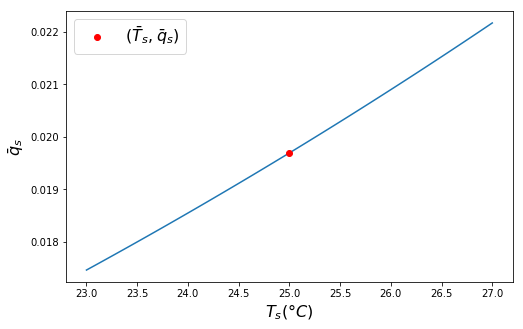

In [63]:
# Find linearization of Q_LH (latent heating), Q_LW (longwave)
# First calculate dq_s/dT
es = es0*np.exp(17.67*(Ts-T0)/(Ts-T0+243.5))
qs = 0.622*es/ps
qsbar = qs[nTs]

plt.figure(figsize=(8,5))
plt.plot(Ts-T0,qs)
plt.plot(Tsbar-T0,qsbar,'ro',label=r'$(\bar T_s,\bar q_s)$')
plt.legend(loc='upper left', fontsize=16)
plt.ylabel(r'$\bar q_s$', fontsize=16)
plt.xlabel(r'$T_s(\degree C)$', fontsize=16)
plt.show()

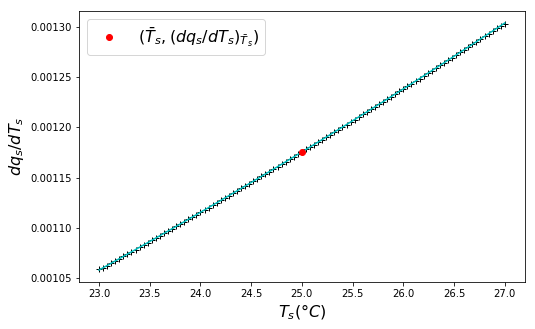

In [16]:
dqsdT = np.gradient(qs)/np.gradient(Ts)
adqsdT = qs*(17.67*243.5)/(Ts-T0+243.5)**2
adqsdTbar = adqsdT[nTs]

plt.figure(figsize=(8,5))
plt.plot(Ts-T0,dqsdT,'+k')
plt.plot(Ts-T0,adqsdT,'c')
plt.plot(Tsbar-T0,adqsdTbar,'ro',label=r'$(\bar T_s,(d q_s/dT_s)_{\bar T_s}$)')
plt.ylabel(r'$d q_s/dT_s$', fontsize=16)
plt.xlabel(r'$T_s(\degree C)$', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.show()

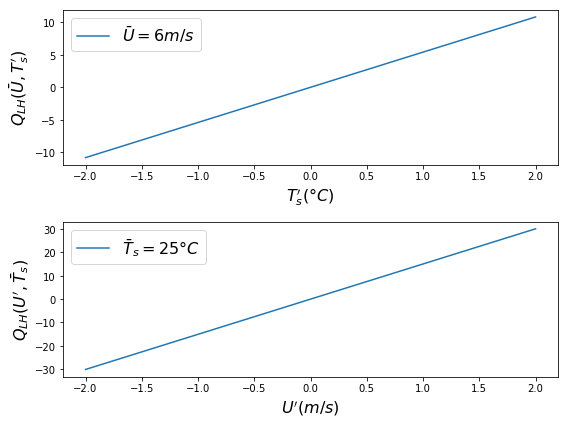

In [17]:
# QLHprime = QLH_umTp + QLH_upTm

consts = rhoa * cE * L * (1-r)
QLH_U = consts * U * qsbar
QLH_qs = consts * Ubar * qs

dQLHdU = np.gradient(QLH_U)/np.gradient(U)
dQLHdTs = np.gradient(QLH_qs)/np.gradient(Ts)
adQLHdTs = consts * Ubar * adqsdTbar 
adQLHdU  = consts * qsbar 
QLH_umTp = adQLHdTs * Tsprime
QLH_upTm = adQLHdU * Uprime

fig = plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(Tsprime,QLH_umTp,label=r'$\bar U = 6 m/s$')
plt.ylabel(r'$Q_{LH} (\bar U, T_s^{\prime})$', fontsize=16)
plt.xlabel(r'$T_s^{\prime}(\degree C)$', fontsize=16)
plt.legend(loc='upper left', fontsize=16)

plt.subplot(212)
plt.plot(Uprime,QLH_upTm,label=r'$\bar T_s = 25\degree C$')
plt.legend(loc='upper left', fontsize=16)
plt.ylabel(r'$Q_{LH} (U^{\prime}, \bar T_s)$', fontsize=16)
plt.xlabel(r'$U^{\prime}(m/s)$', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# QLWprime = QLW_1 + QLW_2
qa = r * qs
ebar = qa * ps / 0.622

#plt.plot(Ts-T0,qa)
#plt.show()

In [19]:
Ta = Ts - delta
clw1 = eps*sigma*(1 - a*C**2) 
QLW1 = clw1*Ta**4*(f1bar - f2*np.sqrt(ebar)) 
QLW2 = 4*eps*sigma*Ts**3*(Ts - Ta)
QLW = QLW1 + QLW2
#f1prime = 0.75/clw1/Ta**4
#plt.plot(f1prime)
#plt.show()

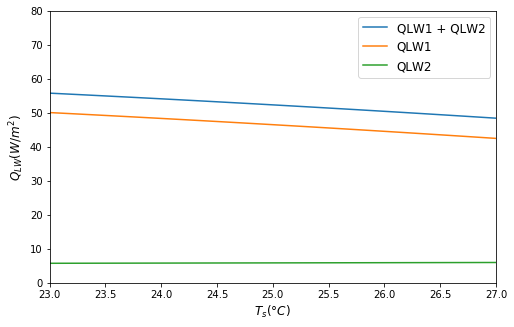

In [30]:
plt.figure(figsize=(8,5))
plt.plot(Ts-T0,QLW,label='QLW1 + QLW2')
plt.plot(Ts-T0,QLW1,label='QLW1')
plt.plot(Ts-T0,QLW2,label='QLW2')
plt.legend(loc='upper right', fontsize=12)
plt.ylabel(r'$Q_{LW}(W/m^2)$', fontsize=12)
plt.xlabel(r'$T_s(\degree C)$', fontsize=12)
plt.axis([23, 27, 0, 80])
plt.show()

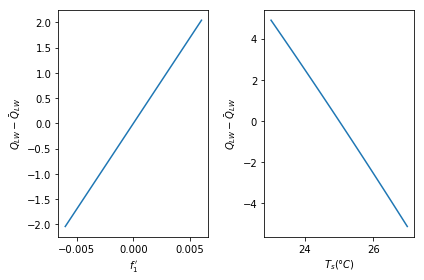

In [21]:
# discrete derivatives:
QLW_f1 = clw1*Tsbar**4 * (f1 - f2*np.sqrt(ebar[nTs])) + 4*eps*sigma*Tsbar**3*delta
QLW_Ts = clw1*Tsbar**4 * (f1bar - f2*np.sqrt(ebar))       + 4*eps*sigma*Ts**3*delta

QLWbar = clw1*Tsbar**4 * (f1bar - f2*np.sqrt(ebar[nTs])) + 4*eps*sigma*Tsbar**3*delta

plt.subplot(121)
plt.plot(f1-f1bar,QLW_f1-QLWbar)
plt.xlabel(r'$f_1^{\,\prime}$')
plt.ylabel(r'$Q_{LW}-\bar Q_{LW}$')
plt.subplot(122)
plt.plot(Ts-T0,QLW_Ts-QLWbar)
plt.xlabel(r'$T_s(\degree C)$')
plt.ylabel(r'$Q_{LW}-\bar Q_{LW}$')
plt.tight_layout()
plt.show()

In [22]:
# analytical derivatives:
adQLWdf1 = clw1*Tsbar**4
adQLWdTs = clw1*Tsbar**3*(4*f1bar - f2*np.sqrt(ebar)*(Tsbar*adqsdTbar/2/qsbar + 4)) + 12*eps*sigma*Tsbar**2*delta

QLWprime = np.zeros((2*nTs+1,2*nf1+1))
QLHprime = np.zeros((2*nTs+1,2*nU+1))

for i in range(0, 2*nf1+1):
    QLWprime[:,i] = adQLWdf1 * f1prime[i] + adQLWdTs * Tsprime[:]
    
for i in range(0, 2*nU+1):
    QLHprime[:,i] = adQLHdU * Uprime[i] + adQLHdTs * Tsprime[:]
        

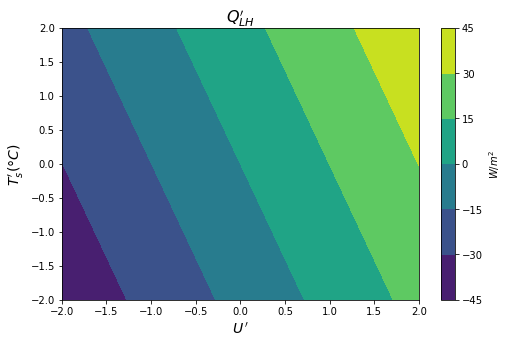

In [23]:
plt.figure(figsize=(8,5))
plt.title(r'$Q_{LH}^\prime$', fontsize=16)
plt.contourf(Uprime,Tsprime,QLHprime)
plt.ylabel(r'$T_s^{ \prime}(\degree C)$', fontsize=14)
plt.xlabel(r'$U^{\,\prime}$', fontsize=14)
cbar=plt.colorbar()
cbar.ax.set_ylabel(r'$W/m^2$', rotation=90) 
plt.show()

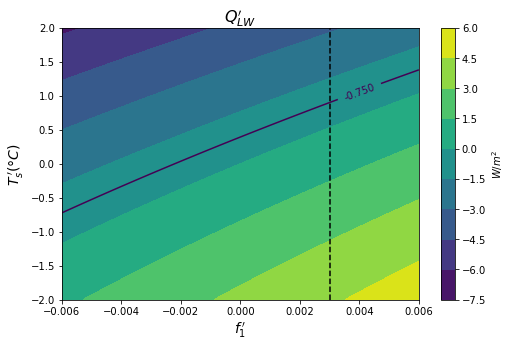

In [43]:
plt.figure(figsize=(8,5))
plt.title(r'$Q_{LW}^\prime$', fontsize=16)
plt.contourf(f1prime,Tsprime,QLWprime)

plt.ylabel(r'$T_s^{\,\prime}(\degree C)$', fontsize=14)
plt.xlabel(r'$f_1^{\,\prime}$', fontsize=14)
cbar=plt.colorbar()
cbar.ax.set_ylabel(r'$W/m^2$', rotation=90) 
CS=plt.contour(f1prime,Tsprime,QLWprime,levels=[-0.75])
plt.plot([0.003,0.003], [-2, 2], 'k--')
plt.clabel(CS, CS.levels)
plt.show()